In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



Frame dimensions: 640x480, Channels: 3


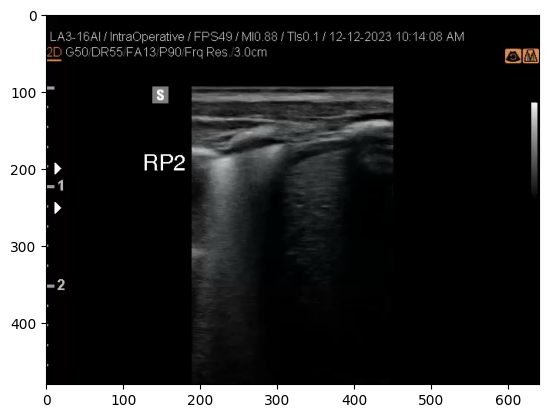

In [36]:

def extract_frame(video_path, frame_number=0):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # print(f"Total frames: {total_frames}")
    # print(f"FPS: {fps}")
    
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read frame
    ret, frame = cap.read()
    
    if not ret or frame is None:
        print("Error: Could not read frame.")
        return None, total_frames, fps
    
    # Release video capture object
    cap.release()

    return frame, total_frames, fps

video_path = '/cosma5/data/durham/dc-fras4/ultrasound/UHW/Case-6-McCormick/MCCORMICK-LU-3/MCCORMICK-LU-3_0007.MP4'


frame, total_frames, fps = extract_frame(video_path, frame_number=0)



plt.imshow(frame)

# find frame size
height, width, channels = frame.shape
print(f"Frame dimensions: {width}x{height}, Channels: {channels}")



In [19]:
# blurred_image = cv2.GaussianBlur(frame, (5, 5), 0.25)

# edges = cv2.Canny(blurred_image,25,100)

# plt.plot(122),plt.imshow(edges,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

# plt.show()

# cdst = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)


In [20]:
# lines = cv2.HoughLines(edges, 1, np.pi / 180, 250, None, 0, 0)

# # Draw the lines
# if lines is not None:
#     for i in range(0, len(lines)):
#         rho = lines[i][0][0]
#         theta = lines[i][0][1]
#         a = math.cos(theta)
#         b = math.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
#         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
#         cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

# plt.figure(figsize=(10, 8))
# plt.imshow(cv2.cvtColor(cdst, cv2.COLOR_BGR2RGB))
# plt.title("Detected Lines (in red) - Standard Hough Line Transform")
# plt.axis('off')
# plt.show()

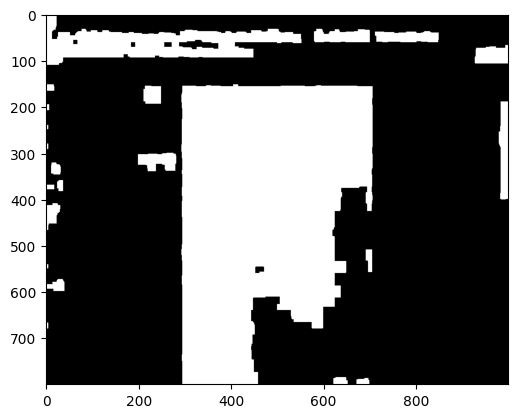

In [34]:
gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

kernel = np.ones((5, 5), np.uint8)  # Define a kernel for morphological operations
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
plt.imshow(mask, cmap='gray')
plt.show()

Largest contour found!
Bounding Box: x=293, y=152, width=414, height=648


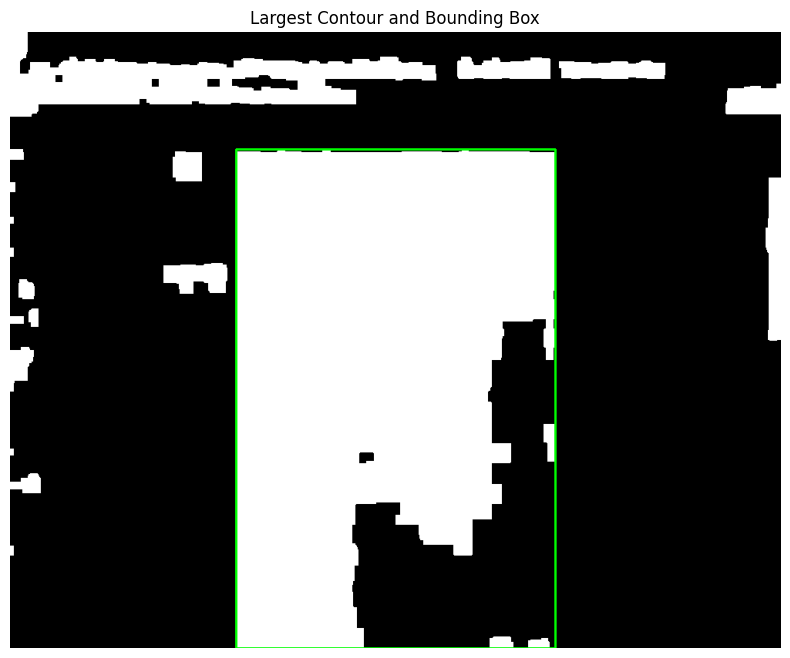

In [35]:



contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- 3. Find the Largest Contour ---
if contours:  # Check if any contours were found
    # Find the contour with the maximum area
    largest_contour = max(contours, key=cv2.contourArea)

    # --- 4. Get the Bounding Box ---
    # Get the (x, y) coordinates and (width, height) of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # --- 5. Visualize the Result ---
    # Create a 3-channel (color) image from the mask to draw on
    output_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Draw a green rectangle (color 0, 255, 0) with thickness 2
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Print the coordinates
    print(f"Largest contour found!")
    print(f"Bounding Box: x={x}, y={y}, width={w}, height={h}")

    # Display the image with the bounding box
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
    plt.title('Largest Contour and Bounding Box')
    plt.axis('off')
    plt.show()

else:
    print("No contours found in the image.")

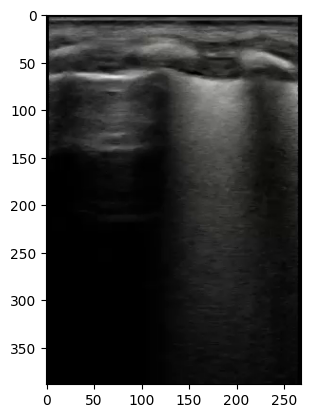

In [15]:
scan_area_cropped = frame[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(scan_area_cropped, cv2.COLOR_BGR2RGB))

B-mode scan bounding box: x=205, y=14, width=599, height=202


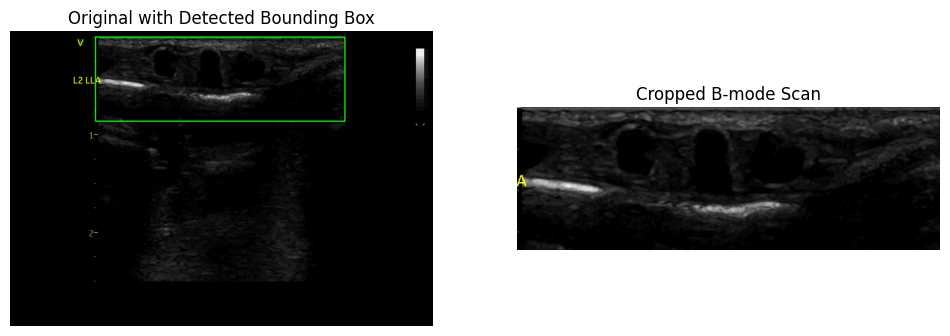

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Your Original Image (from your example) ---
# Replace 'path/to/your/image.png' with the actual path to your image
# Make sure to load the original image, not the binary mask, as we'll create the mask here.
image_path = 'your_ultrasound_frame.png' # You'll need to save your example image with this name
original_frame = frame

if original_frame is None:
    print(f"Error: Could not load image from {image_path}")
else:
    # --- 2. Convert to Grayscale ---
    gray_frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY)

    # --- 3. Create Binary Mask ---
    # Pixels that are not pure black (intensity > 0) become white (255)
    # Adjust the threshold if necessary. Sometimes 5 or 10 might be better than 1 if there's very dark noise.
    _, mask = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # --- (Optional) Morphological Operations for Cleaning ---
    # This can help remove small noise specks and connect broken parts within scan regions
    kernel = np.ones((5,5), np.uint8) # Adjust kernel size if needed
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # Fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small external noise

    # --- 4. Find All Contours ---
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- 5. Filter and Identify the Target Contour (B-mode scan) ---
    min_contour_area = 1000 # Adjust this threshold based on typical text/noise size
    b_mode_contour = None
    min_y = float('inf') # Initialize with a very large y-coordinate

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_contour_area:
            x, y, w, h = cv2.boundingRect(contour)

            # Check if this contour is higher up (smaller y-coordinate) than previous ones
            # AND if it meets some aspect ratio expectations for the B-mode scan (optional, but good for robustness)
            # A typical B-mode scan is often taller than it is wide, or roughly square.
            # An M-mode scan is usually much wider than it is tall.
            # You might need to adjust the aspect ratio condition based on your actual data.
            aspect_ratio = w / h
            
            # Simple check for position (smallest y) and maybe a rough aspect ratio constraint
            # Example: assuming B-mode is roughly between 0.5 and 2.0 aspect ratio
            if y < min_y: # and 0.5 < aspect_ratio < 2.5: # Uncomment aspect ratio if needed
                min_y = y
                b_mode_contour = contour

    # --- 6. Get the Bounding Box for the Identified B-mode Scan ---
    if b_mode_contour is not None:
        x, y, w, h = cv2.boundingRect(b_mode_contour)

        # --- 7. Crop the Original Frame ---
        cropped_frame = original_frame[y : y + h, x : x + w]

        # --- 8. Visualize Results ---
        # Create a copy to draw on for visualization (optional)
        display_frame = original_frame.copy()
        cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green rectangle

        print(f"B-mode scan bounding box: x={x}, y={y}, width={w}, height={h}")

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
        plt.title('Original with Detected Bounding Box')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
        plt.title('Cropped B-mode Scan')
        plt.axis('off')

        plt.show()

    else:
        print("No significant B-mode contour found.")